In [1]:
import ollama
from ollama import chat

from huggingface_hub import snapshot_download

from docling.datamodel.pipeline_options import PdfPipelineOptions, RapidOcrOptions, PictureDescriptionApiOptions
from docling.backend.pypdfium2_backend import PyPdfiumDocumentBackend
from docling.datamodel.base_models import InputFormat
from docling.document_converter import DocumentConverter, PdfFormatOption
from docling.chunking import HybridChunker
from docling_core.types.doc import PictureItem, TableItem, TextItem
from docling_core.types.doc.labels import DocItemLabel

from pydantic.v1 import BaseModel

from transformers import AutoTokenizer
from sentence_transformers import CrossEncoder

from BM25 import load_bm25, create_bm25, bm25_search
from util.docling_util import *
from util.qdrant_util import qdrant_DBConnector, DataObject
from util.text_splitter import RecursiveTextSplitter, DataFrameFormatter
from util.ollama_util import *

import os
import json
from pathlib import Path

from openai import OpenAI
from dotenv import load_dotenv, find_dotenv

import uuid

/Users/yoyo/opt/anaconda3/envs/cathay_llm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
do_ocr = False
do_image_summary = True

kb_name = "test_kb"
kb_id = str(uuid.uuid4())[:8]
new_kb_name = f"{kb_name}_{kb_id}"

In [3]:
# document local path or URL
doc = "./test_doc/國泰人壽祿美富利率變動型美元終身壽險（定期給付型）.pdf" # simple text with a image and table
doc1 = "./test_doc/吉美利101利率變動型美元終身壽險(定期給付型)DM.pdf" # complex text with simple aesthetic table
doc2 = "./test_doc/美利雙寶利率變動型美元終身保險 (定期給付型)DM.pdf" # complex text with complex aesthetic table
doc3 = "./test_doc/國泰金控出勤管理須知(修正後).pdf" # simple text with a simple table
doc4 = "./test_doc/國泰金控員工國內出差要點.pdf" # simple text with a simple table
doc5 = "./test_doc/國泰金控員工國外出差要點.pdf" # simple text with complex table
doc6 = "./test_doc/國泰金融控股股份有限公司資訊安全管理辦法.pdf" # simple text
doc7 = "./test_doc/國泰金融控股股份有限公司_後台維護系統管理作業要點_F.pdf" # flow map with blank table
doc8 = "./test_doc/國泰金融控股股份有限公司金融科技創新業務管理辦法_20240125.pdf" # flow map
doc9 = "./test_doc/國泰金控暨子公司「對話機器人 - 阿發」視覺形象管理辦法.pdf" # complex figure design doc
doc10 = "./test_doc/國泰醫院113年工作計畫.pdf" # cross page table and HAS index, scanned document OCR needed
doc11 = "./test_doc/國泰醫院113年經費預算.pdf" # large number table, scanned document OCR needed
doc12 = "./test_doc/國泰醫院112年工作報告.pdf" # table with check board inside, scanned document OCR needed
doc13 = "./test_doc/112年國泰醫療財團法人財務報告.pdf" # loose structured table, scanned document OCR needed
doc14 = "./test_doc/111年4-6月愛心捐款及捐贈物資徵信名冊.pdf" #compacted table
doc15 = "./test_doc/畢業學分審核表.pdf" # vertical table

# ollama embedding model
embed_model = "bge-m3:latest"

# reranker 
rerank_model = CrossEncoder('BAAI/bge-reranker-v2-m3', max_length=1024)

# ollama llm
#llm = "deepseek-r1:14b-max-context"
llm = "deepseek-r1:14b-quarter-context"
#llm = "deepseek-r1:14b-eighth-context"

if do_ocr:
    # PyPdfium with RapidOCR
    # ----------------------
    # Download RappidOCR models from HuggingFace
    print("Downloading RapidOCR models")
    download_path = snapshot_download(repo_id="SWHL/RapidOCR")

    det_model_path = os.path.join(
        download_path, "PP-OCRv4", "ch_PP-OCRv4_det_infer.onnx"
    )
    rec_model_path = os.path.join(
        download_path, "PP-OCRv4", "ch_PP-OCRv4_rec_infer.onnx"
    )
    cls_model_path = os.path.join(
        download_path, "PP-OCRv3", "ch_ppocr_mobile_v2.0_cls_train.onnx"
    )
    ocr_options = RapidOcrOptions(
        det_model_path=det_model_path,
        rec_model_path=rec_model_path,
        cls_model_path=cls_model_path,
        #force_full_page_ocr=True
    )

    pipeline_options = PdfPipelineOptions()

    pipeline_options.do_ocr = True
    pipeline_options.do_table_structure = True
    pipeline_options.table_structure_options.do_cell_matching = True
    pipeline_options.table_structure_options.mode = 'accurate'

    pipeline_options.images_scale = 2.0
    pipeline_options.generate_page_images = True
    pipeline_options.generate_picture_images = True

    pipeline_options.ocr_options = ocr_options

    pypdfium_converter = DocumentConverter(
        format_options={
            InputFormat.PDF: PdfFormatOption(
            pipeline_options=pipeline_options, backend=PyPdfiumDocumentBackend
            )
    }
    )

else:
    # PyPdfium without EasyOCR
    # --------------------
    pipeline_options = PdfPipelineOptions()
    pipeline_options.do_ocr = False
    pipeline_options.do_table_structure = True
    pipeline_options.table_structure_options.do_cell_matching = False
    #pipeline_options.table_structure_options.do_cell_matching = True

    #pipeline_options.table_structure_options.mode = 'accurate'

    pipeline_options.images_scale = 2
    pipeline_options.generate_page_images = True
    pipeline_options.generate_picture_images = True

    pypdfium_converter = DocumentConverter(
        format_options={
            InputFormat.PDF: PdfFormatOption(
            pipeline_options=pipeline_options, backend=PyPdfiumDocumentBackend
            )
        }
    )

# print json
def show_json(data):
    if isinstance(data, str):
        obj = json.loads(data)
        print(json.dumps(obj, indent=4, ensure_ascii=False))
    elif isinstance(data, dict) or isinstance(data, list):
        print(json.dumps(data, indent=4, ensure_ascii=False))
    elif issubclass(type(data), BaseModel):
        print(json.dumps(data.dict(), indent=4, ensure_ascii=False))

In [4]:
UPLOAD_FOLDER = './test_fake_uploads'
os.makedirs(UPLOAD_FOLDER, exist_ok=True)

def save2fakeuploads(doc_paths):
    new_doc_sources = []
    for path in doc_paths:
        file_name = os.path.basename(path)
        basename, file_ext = os.path.splitext(file_name)

        safe_basename = ''.join(c for c in basename if c.isalnum() or '\u4e00' <= c <= '\u9fff')[:30]
        file_id = str(uuid.uuid4())[:8]
        new_filename = f"{safe_basename}_{file_id}{file_ext}"
        file_path = os.path.join(UPLOAD_FOLDER, new_filename)
        with open(path, "rb") as f_in, open(file_path, "wb") as f_out:
            f_out.write(f_in.read())
        new_doc_sources.append(file_path)
    return new_doc_sources

# Docling reader, docling format parser output

In [5]:
#doc_source = [doc15]                                       # vertical table

#doc_source = [doc, doc7, doc8]                             # image caption required
#doc_source = [doc1, doc2, doc3, doc4, doc5, doc6, doc14]   # text and table
#doc_source = [doc10, doc11, doc12, doc13]                  # OCR required

doc_source = [doc5, doc7] 

new_doc_sources = save2fakeuploads(doc_source)

conv_results = pypdfium_converter.convert_all(
    new_doc_sources,
    #doc_source,
    raises_on_error=True,  # to let conversion run through all and examine results at the end
)

conv_results_list = list(conv_results)

# Do hybrid chunking to merge similar chunk
tokenizer = AutoTokenizer.from_pretrained("BAAI/bge-m3")

"""hybrid_chunker = HybridChunker(
    tokenizer=tokenizer,
    max_tokens=8000,
    merge_peers=True  # optional, defaults to True
)

# text chunks
all_chunks = []
for conv_res in conv_results_list:
    docling_docs = conv_res.document
    chunk_iter = hybrid_chunker.chunk(dl_doc=docling_docs)
    chunks = list(chunk_iter)
    all_chunks += chunks"""


'hybrid_chunker = HybridChunker(\n    tokenizer=tokenizer,\n    max_tokens=8000,\n    merge_peers=True  # optional, defaults to True\n)\n\n# text chunks\nall_chunks = []\nfor conv_res in conv_results_list:\n    docling_docs = conv_res.document\n    chunk_iter = hybrid_chunker.chunk(dl_doc=docling_docs)\n    chunks = list(chunk_iter)\n    all_chunks += chunks'

self_ref='#/texts/0' parent=RefItem(cref='#/body') children=[] content_layer=<ContentLayer.BODY: 'body'> label=<DocItemLabel.SECTION_HEADER: 'section_header'> prov=[ProvenanceItem(page_no=1, bbox=BoundingBox(l=161.00750732421875, t=765.7791748046875, r=426.29364013671875, b=751.0201416015625, coord_origin=<CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>), charspan=(0, 22))] orig='國泰優惠 APP 後P 後台維護系統管理要點' text='國泰優惠 APP 後P 後台維護系統管理要點' formatting=None hyperlink=None level=1
self_ref='#/texts/1' parent=RefItem(cref='#/body') children=[] content_layer=<ContentLayer.BODY: 'body'> label=<DocItemLabel.TEXT: 'text'> prov=[ProvenanceItem(page_no=1, bbox=BoundingBox(l=366.64801025390625, t=724.0700073242188, r=541.9409790039062, b=692.9979858398438, coord_origin=<CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>), charspan=(0, 55))] orig='中華民國 108 年 10 月 05 日5 日訂日訂定 中華民國 111 年 10 月 13 日3 日修日修訂' text='中華民國 108 年 10 月 05 日5 日訂日訂定 中華民國 111 年 10 月 13 日3 日修日修訂' formatting=None hyperlink=None
self_ref='#/texts/2' parent=Ref
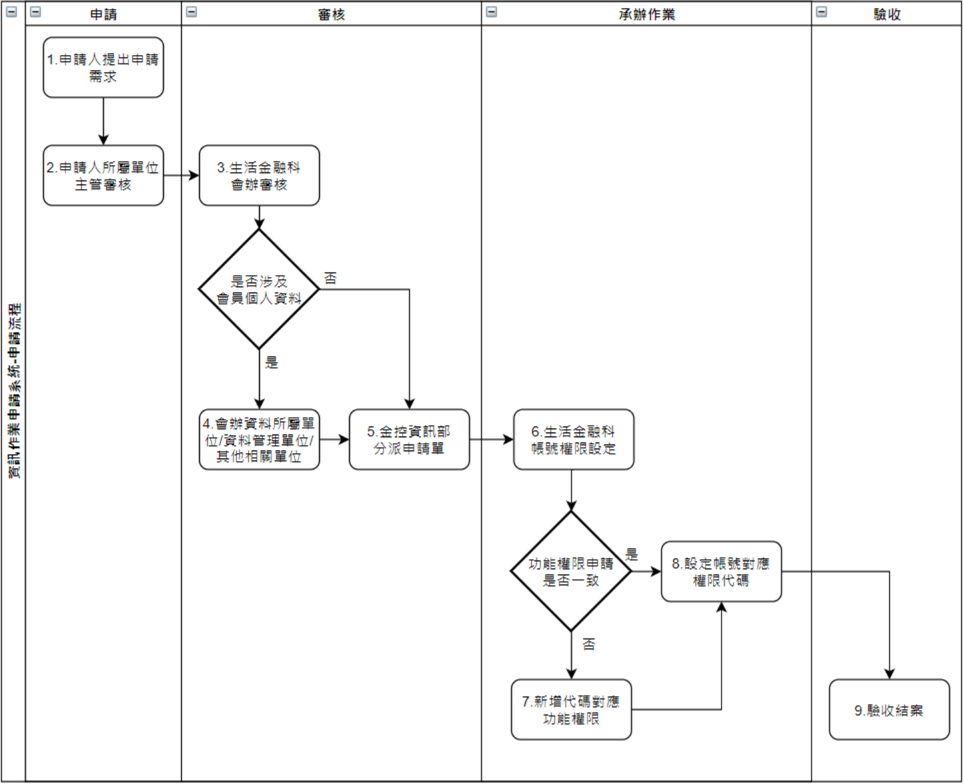
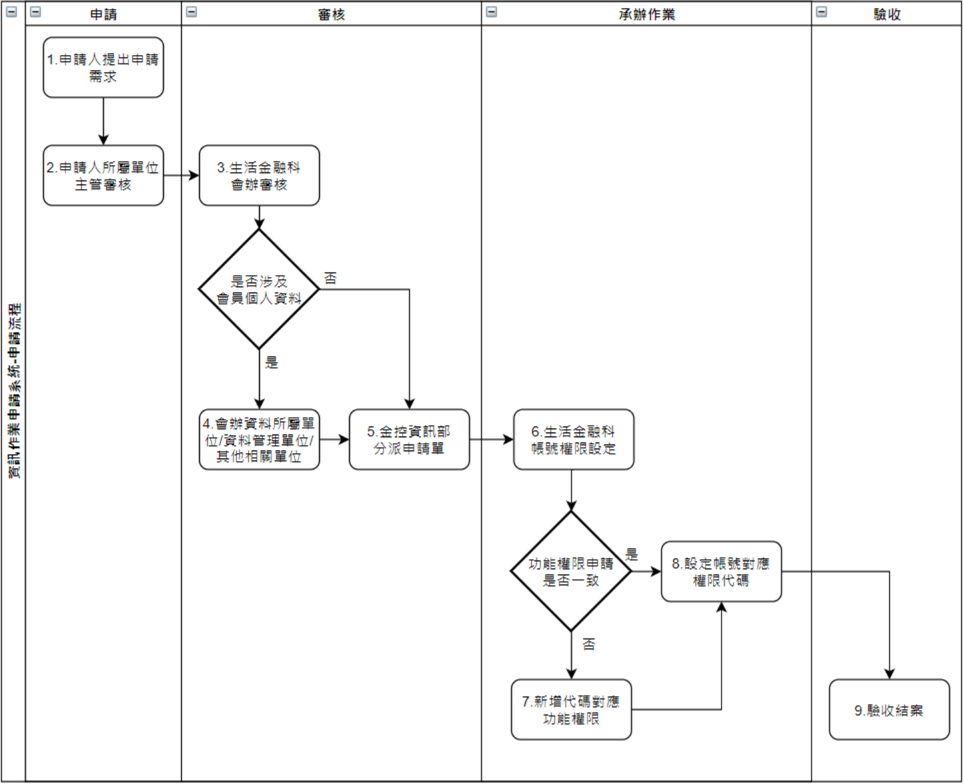

In [37]:
for e, _level in conv_results_list[1].document.iterate_items():
    print(e)

In [6]:
if do_image_summary:
    output_dir = Path("figure_storage")
    output_dir.mkdir(parents=True, exist_ok=True)

    #figure_summary_chunks = []

    # Save images of figures and tables for later summary generation
    for conv_res in conv_results_list:
        docling_docs = conv_res.document
        doc_filename = conv_res.input.file.stem
        #table_counter = 0
        picture_counter = 0
        
        for element, _level in docling_docs.iterate_items():
            #print(element)
            """if isinstance(element, TableItem):
                table_counter += 1
                element_image_filename = (
                    output_dir / f"{doc_filename}-table-{table_counter}.png"
                )
                with element_image_filename.open("wb") as fp:
                    element.get_image(conv_res.document).save(fp, "PNG")"""

            if isinstance(element, PictureItem):
                #print(element)
                #print("========================== picture here ==========================")
                original_parent = element.parent
                #original_children  =element.children
                original_content_layer = element.content_layer
                original_prov = element.prov
                image_uri = element.image.uri

                picture_counter += 1
                element_image_filename = (
                    output_dir / f"{doc_filename}-picture-{picture_counter}.png"
                )
                with element_image_filename.open("wb") as fp:
                    element.get_image(docling_docs).save(fp, "PNG")

                element_image_path = f"./{element_image_filename}"
                image_encoded = encode_image(element_image_path)

                #summary = summarize_image_openai(doc_filename, image_encoded)
                summary="aaaa"

                image_replace_textItem = TextItem(
                    self_ref="#",
                    text=f"<replacement_of:{element_image_filename}>{summary}",
                    orig=f"<replacement_of:{element_image_filename}>{summary}",
                    label=DocItemLabel.TEXT,
                    parent=original_parent,
                    #children=original_children,
                    content_layer=original_content_layer,
                    prov=original_prov,
                    hyperlink = image_uri
                )
                #print(image_replace_textItem)

                #docling_docs.replace_item(old_item=element, new_item=image_replace_textItem)
                docling_docs.insert_item_after_sibling(new_item=image_replace_textItem, sibling=element)

                #summary_chunk_meta = {"filename": doc_filename, "figure_path": element_image_path}
                #summary_chunk_pair = [(summary, summary_chunk_meta)]
                #figure_summary_chunks.extend(summary_chunk_pair)

In [7]:
hybrid_chunker = HybridChunker(
    tokenizer=tokenizer,
    max_tokens=8000,
    merge_peers=True,  # optional, defaults to True
    serializer_provider = PatchedChunkingSerializerProvider()
)

# text chunks
all_chunks = []
for conv_res in conv_results_list:
    docling_docs = conv_res.document
    chunk_iter = hybrid_chunker.chunk(dl_doc=docling_docs)
    chunks = list(chunk_iter)
    all_chunks += chunks

In [8]:
for i, chunk in enumerate(all_chunks[:]):
    print(f"=== {i} ===")
    txt_tokens = len(tokenizer.tokenize(chunk.text))
    print(f"chunk.text ({txt_tokens} tokens):\n{repr(chunk.text)}")

    ser_txt = hybrid_chunker.serialize(chunk=chunk)
    ser_tokens = len(tokenizer.tokenize(ser_txt))
    print(f"chunker.serialize(chunk) ({ser_tokens} tokens):\n{repr(ser_txt)}")
    #print(f"chunker.serialize(chunk) ({ser_tokens} tokens):\n{ser_txt}")

    print(chunk.meta)

    print()

=== 0 ===
chunk.text (24 tokens):
'為使本公司員工赴國外出差、考察或受訓等有所依循，特訂定本要點。'
chunker.serialize(chunk) (34 tokens):
'第-條目(目條(目的)\n為使本公司員工赴國外出差、考察或受訓等有所依循，特訂定本要點。'
schema_name='docling_core.transforms.chunker.DocMeta' version='1.0.0' doc_items=[DocItem(self_ref='#/texts/1', parent=RefItem(cref='#/body'), children=[], content_layer=<ContentLayer.BODY: 'body'>, label=<DocItemLabel.TEXT: 'text'>, prov=[ProvenanceItem(page_no=1, bbox=BoundingBox(l=50.25600051879883, t=497.4100036621094, r=418.3080139160156, b=486.1780090332031, coord_origin=<CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>), charspan=(0, 31))])] headings=['第-條目(目條(目的)'] captions=None origin=DocumentOrigin(mimetype='application/pdf', binary_hash=7244028254081051532, filename='國泰金控員工國外出差要點_8593e20b.pdf', uri=None)

=== 1 ===
chunk.text (56 tokens):
'奉派出國人員其差旅費用悉依本辦法規定辦理，但因業務需求或有特殊原因，處級主管(含(含)以上 經總經理、處級主管(不含)以下經處級主管同意者，不在此限。'
chunker.serialize(chunk) (58 tokens):
'第二條\n奉派出國人員其差旅費用悉依本辦法規定辦理，但因業務需求或有特殊原因，處級主管(含(含)以上 經總經理、處級主管(不含)以下經處級主管同意者，不在此限。'
sc

/var/folders/v7/_g3b28s51m532s03dhwffy9c0000gn/T/ipykernel_63623/2500604497.py:6: DeprecationWarning: Use contextualize() instead.
  ser_txt = hybrid_chunker.serialize(chunk=chunk)


In [9]:
if do_image_summary:
    for i, chunk in enumerate(all_chunks):
        ser_txt = hybrid_chunker.contextualize(chunk=chunk)
        if re.search(r"<[^>]+>", ser_txt):
            clean_text, replacement_paths = replace_image_tag(ser_txt)
            chunk_text = clean_text
            chunk_meta = chunk.meta.export_json_dict()
            chunk_meta["replacement_paths"] = replacement_paths
            chunk_pair = (chunk_text, chunk_meta)
            all_chunks[i] = chunk_pair

# Rechunk large chunks with RecursiveTextSplitter

In [10]:
big_chunk = []

for i, chunk in enumerate(all_chunks[:]):
    if type(chunk) == tuple:
        ser_txt = chunk[0]
    else:
        ser_txt = hybrid_chunker.serialize(chunk=chunk)
    ser_tokens = len(tokenizer.tokenize(ser_txt))
    if ser_tokens > 1024:
        print(f"=== {i} ===")
        #print(f"chunker.serialize(chunk) ({ser_tokens} tokens):\n{repr(ser_txt)}")
        print(f"chunker.serialize(chunk) ({ser_tokens} tokens):\n{ser_txt}")
        big_chunk.append(chunk)
        print()
    else:
        pass

=== 9 ===
chunker.serialize(chunk) (6460 tokens):
附表-：跨境差旅-宿費及餐雜費標準
單位：美元日/日元/日
亞洲地區, 總經理級以上主管   宿費 餐雜費.宿費 = . 亞洲地區, 總經理級以上主管   宿費 餐雜費.餐雜費 = . 亞洲地區, 高階主管.宿費 = . 亞洲地區, 高階主管.餐雜費 = . 亞洲地區, 協理級(含)   以下人員   宿費 餐雜費.宿費 = . 亞洲地區, 協理級(含)   以下人員   宿費 餐雜費.餐雜費 = . 中國大陸, 總經理級以上主管   宿費 餐雜費.宿費 = 檢據實支. 中國大陸, 總經理級以上主管   宿費 餐雜費.餐雜費 = 110或檢據實支. 中國大陸, 高階主管.宿費 = 270. 中國大陸, 高階主管.餐雜費 = 110. 中國大陸, 協理級(含)   以下人員   宿費 餐雜費.宿費 = 215. 中國大陸, 協理級(含)   以下人員   宿費 餐雜費.餐雜費 = 95. 日本(Japan), 總經理級以上主管   宿費 餐雜費.宿費 = 檢據實支. 日本(Japan), 總經理級以上主管   宿費 餐雜費.餐雜費 = 140或檢據實支. 日本(Japan), 高階主管.宿費 = 345. 日本(Japan), 高階主管.餐雜費 = 140. 日本(Japan), 協理級(含)   以下人員   宿費 餐雜費.宿費 = 275. 日本(Japan), 協理級(含)   以下人員   宿費 餐雜費.餐雜費 = 105. 南韓(Korea), 總經理級以上主管   宿費 餐雜費.宿費 = 檢據實支. 南韓(Korea), 總經理級以上主管   宿費 餐雜費.餐雜費 = 130或檢據實支. 南韓(Korea), 高階主管.宿費 = 315. 南韓(Korea), 高階主管.餐雜費 = 130. 南韓(Korea), 協理級(含)   以下人員   宿費 餐雜費.宿費 = 255. 南韓(Korea), 協理級(含)   以下人員   宿費 餐雜費.餐雜費 = 110. 菲律賓(Philippines), 總經理級以上主管   宿費 餐雜費.宿費 = 檢據實支. 菲律賓(Philippines), 總經理級以上主管   宿費 餐雜費.餐雜費 = 105或檢據實支

/var/folders/v7/_g3b28s51m532s03dhwffy9c0000gn/T/ipykernel_63623/499157167.py:7: DeprecationWarning: Use contextualize() instead.
  ser_txt = hybrid_chunker.serialize(chunk=chunk)


In [11]:
splitter = RecursiveTextSplitter(tokenizer=tokenizer, max_tokens=1024, overlap=150, min_length_ratio=1)

rechunked_large_chunks = []

for i, chunk in enumerate(big_chunk):
    if type(chunk) == tuple:
        ser_txt = chunk[0]
    else:
        ser_txt = hybrid_chunker.serialize(chunk=chunk)
        
    if splitter.tokenize_len(ser_txt) > splitter.max_tokens:
        sub_chunks = splitter.split_text(ser_txt)
        sub_chunks_meta = {"filename": chunk.meta.origin.filename}
        sub_chunks_pair = [(text, sub_chunks_meta) for text in sub_chunks]
        rechunked_large_chunks.extend(sub_chunks_pair)
    else:
        rechunked_large_chunks.append(ser_txt)

/var/folders/v7/_g3b28s51m532s03dhwffy9c0000gn/T/ipykernel_63623/2118950735.py:9: DeprecationWarning: Use contextualize() instead.
  ser_txt = hybrid_chunker.serialize(chunk=chunk)


In [12]:
for i, chunk in enumerate(rechunked_large_chunks[:]):
    
    ser_txt = chunk[0]
    ser_tokens = len(tokenizer.tokenize(ser_txt))

    print(f"=== {i} ===")
    #print(f"chunker.serialize(chunk) ({ser_tokens} tokens):\n{repr(ser_txt)}")
    print(f"chunker.serialize(chunk) ({ser_tokens} tokens):\n{ser_txt}")
    print(chunk[1])

    print()

=== 0 ===
chunker.serialize(chunk) (1018 tokens):
附表-:跨境差旅-宿費及餐雜費標準 單位:美元日/日元/日 亞洲地區, 總經理級以上主管 宿費 餐雜費.宿費 =. 亞洲地區, 總經理級以上主管 宿費 餐雜費.餐雜費 =. 亞洲地區, 高階主管.宿費 =. 亞洲地區, 高階主管.餐雜費 =. 亞洲地區, 協理級(含) 以下人員 宿費 餐雜費.宿費 =. 亞洲地區, 協理級(含) 以下人員 宿費 餐雜費.餐雜費 =. 中國大陸, 總經理級以上主管 宿費 餐雜費.宿費 = 檢據實支. 中國大陸, 總經理級以上主管 宿費 餐雜費.餐雜費 = 110或檢據實支. 中國大陸, 高階主管.宿費 = 270. 中國大陸, 高階主管.餐雜費 = 110. 中國大陸, 協理級(含) 以下人員 宿費 餐雜費.宿費 = 215. 中國大陸, 協理級(含) 以下人員 宿費 餐雜費.餐雜費 = 95. 日本(Japan), 總經理級以上主管 宿費 餐雜費.宿費 = 檢據實支. 日本(Japan), 總經理級以上主管 宿費 餐雜費.餐雜費 = 140或檢據實支. 日本(Japan), 高階主管.宿費 = 345. 日本(Japan), 高階主管.餐雜費 = 140. 日本(Japan), 協理級(含) 以下人員 宿費 餐雜費.宿費 = 275. 日本(Japan), 協理級(含) 以下人員 宿費 餐雜費.餐雜費 = 105. 南韓(Korea), 總經理級以上主管 宿費 餐雜費.宿費 = 檢據實支. 南韓(Korea), 總經理級以上主管 宿費 餐雜費.餐雜費 = 130或檢據實支. 南韓(Korea), 高階主管.宿費 = 315. 南韓(Korea), 高階主管.餐雜費 = 130. 南韓(Korea), 協理級(含) 以下人員 宿費 餐雜費.宿費 = 255. 南韓(Korea), 協理級(含) 以下人員 宿費 餐雜費.餐雜費 = 110. 菲律賓(Philippines), 總經理級以上主管 宿費 餐雜費.宿費 = 檢據實支. 菲律賓(Philippines), 總經理級以上主管 宿費 餐雜費.餐雜費 = 105或檢據實支. 菲律賓(Philippines), 高階主管.宿費 = 260. 菲律賓(Philippines), 高階主管.

# Or table extraction result

In [13]:
# table chunks
all_tables = extract_tables(conv_results_list)

In [14]:
table_formatter = DataFrameFormatter(tokenizer=tokenizer, show_index=False, max_tokens=1024)

table_chunks = []
for table in all_tables:
    chunks = table_formatter.chunk_rows(table[0])
    chunks_pair = [(text, table[1]) for text in chunks]
    table_chunks.extend(chunks_pair)

In [16]:
for i, chunk in enumerate(table_chunks[:]):
    
    ser_txt = chunk[0]
    ser_tokens = len(tokenizer.tokenize(ser_txt))

    print(f"=== {i} ===")
    #print(f"chunker.serialize(chunk) ({ser_tokens} tokens):\n{repr(ser_txt)}")
    print(f"chunker.serialize(chunk) ({ser_tokens} tokens):\n{ser_txt}")
    print(chunk[1])
    print()

=== 0 ===
chunker.serialize(chunk) (922 tokens):
名稱(地區、國家、城市或其他). = 亞洲地區
名稱(地區、國家、城市或其他). = 中國大陸, 總經理級以上主管   宿費 餐雜費.宿費 = 檢據實支, 總經理級以上主管   宿費 餐雜費.餐雜費 = 110或檢據實支, 高階主管.宿費 = 270, 高階主管.餐雜費 = 110, 協理級(含)   以下人員   宿費 餐雜費.宿費 = 215, 協理級(含)   以下人員   宿費 餐雜費.餐雜費 = 95
名稱(地區、國家、城市或其他). = 日本(Japan), 總經理級以上主管   宿費 餐雜費.宿費 = 檢據實支, 總經理級以上主管   宿費 餐雜費.餐雜費 = 140或檢據實支, 高階主管.宿費 = 345, 高階主管.餐雜費 = 140, 協理級(含)   以下人員   宿費 餐雜費.宿費 = 275, 協理級(含)   以下人員   宿費 餐雜費.餐雜費 = 105
名稱(地區、國家、城市或其他). = 南韓(Korea), 總經理級以上主管   宿費 餐雜費.宿費 = 檢據實支, 總經理級以上主管   宿費 餐雜費.餐雜費 = 130或檢據實支, 高階主管.宿費 = 315, 高階主管.餐雜費 = 130, 協理級(含)   以下人員   宿費 餐雜費.宿費 = 255, 協理級(含)   以下人員   宿費 餐雜費.餐雜費 = 110
名稱(地區、國家、城市或其他). = 菲律賓(Philippines), 總經理級以上主管   宿費 餐雜費.宿費 = 檢據實支, 總經理級以上主管   宿費 餐雜費.餐雜費 = 105或檢據實支, 高階主管.宿費 = 260, 高階主管.餐雜費 = 105, 協理級(含)   以下人員   宿費 餐雜費.宿費 = 210, 協理級(含)   以下人員   宿費 餐雜費.餐雜費 = 85
名稱(地區、國家、城市或其他). = 泰國(Thailand), 總經理級以上主管   宿費 餐雜費.宿費 = 檢據實支, 總經理級以上主管   宿費 餐雜費.餐雜費 = 100或檢據實支, 高階主管.宿費 = 245, 高階主管.餐雜費 = 100, 協理級(含)   以下人員   宿費 餐雜費.宿費 = 200, 協理級(含) 

# Merge all chunks

In [17]:
all_chunks.extend(rechunked_large_chunks)
all_chunks.extend(table_chunks)
#all_chunks.extend(figure_summary_chunks)
all_chunks

[DocChunk(text='為使本公司員工赴國外出差、考察或受訓等有所依循，特訂定本要點。', meta=DocMeta(schema_name='docling_core.transforms.chunker.DocMeta', version='1.0.0', doc_items=[DocItem(self_ref='#/texts/1', parent=RefItem(cref='#/body'), children=[], content_layer=<ContentLayer.BODY: 'body'>, label=<DocItemLabel.TEXT: 'text'>, prov=[ProvenanceItem(page_no=1, bbox=BoundingBox(l=50.25600051879883, t=497.4100036621094, r=418.3080139160156, b=486.1780090332031, coord_origin=<CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>), charspan=(0, 31))])], headings=['第-條目(目條(目的)'], captions=None, origin=DocumentOrigin(mimetype='application/pdf', binary_hash=7244028254081051532, filename='國泰金控員工國外出差要點_8593e20b.pdf', uri=None))),
 DocChunk(text='奉派出國人員其差旅費用悉依本辦法規定辦理，但因業務需求或有特殊原因，處級主管(含(含)以上 經總經理、處級主管(不含)以下經處級主管同意者，不在此限。', meta=DocMeta(schema_name='docling_core.transforms.chunker.DocMeta', version='1.0.0', doc_items=[DocItem(self_ref='#/texts/3', parent=RefItem(cref='#/body'), children=[], content_layer=<ContentLayer.BODY: 'body'>, label=<DocI

In [25]:
all_chunks[0].meta.export_json_dict().get("origin", {}).get("filename")

'國泰金控員工國外出差要點_8593e20b.pdf'

In [ ]:
node_text, node_metadatas = [], []
for chunk in all_chunks:
    if type(chunk) == tuple:
        node_text.append(chunk[0])
        meta_dict = chunk[1]
        #node_metadatas.append(json.dumps(meta_dict, indent=4, ensure_ascii=False))
        node_metadatas.append(meta_dict)
    else:
        node_text.append(hybrid_chunker.serialize(chunk=chunk))
        node_metadatas.append(chunk.meta.export_json_dict())

In [26]:
node_text, node_metadatas = [], []
for chunk in all_chunks:
    if type(chunk) == tuple:
        node_text.append(chunk[0])
        meta_dict = chunk[1].copy()

        file_name = meta_dict.get("filename") or meta_dict.get("origin", {}).get("filename")
        basename, _ = os.path.splitext(file_name)
        file_id = basename.split('_')[-1]
        meta_dict["file_id"] = file_id
        meta_dict["kb_name"] = new_kb_name
        meta_dict["kb_id"] = kb_id
        #node_metadatas.append(json.dumps(meta_dict, indent=4, ensure_ascii=False))
        node_metadatas.append(meta_dict)
    else:
        node_text.append(hybrid_chunker.serialize(chunk=chunk))
        meta_dict = chunk.meta.export_json_dict()
        file_name = meta_dict.get("origin", {}).get("filename")
        basename, _ = os.path.splitext(file_name)
        file_id = basename.split('_')[-1]
        meta_dict["file_id"] = file_id
        meta_dict["kb_name"] = new_kb_name
        meta_dict["kb_id"] = kb_id
        #node_metadatas.append(json.dumps(meta_dict, indent=4, ensure_ascii=False))
        node_metadatas.append(meta_dict)

/var/folders/v7/_g3b28s51m532s03dhwffy9c0000gn/T/ipykernel_63623/3606386783.py:16: DeprecationWarning: Use contextualize() instead.
  node_text.append(hybrid_chunker.serialize(chunk=chunk))


In [29]:
for i in node_metadatas:
    print(i)
    print()

{'schema_name': 'docling_core.transforms.chunker.DocMeta', 'version': '1.0.0', 'doc_items': [{'self_ref': '#/texts/1', 'parent': {'$ref': '#/body'}, 'children': [], 'content_layer': 'body', 'label': 'text', 'prov': [{'page_no': 1, 'bbox': {'l': 50.25600051879883, 't': 497.4100036621094, 'r': 418.3080139160156, 'b': 486.1780090332031, 'coord_origin': 'BOTTOMLEFT'}, 'charspan': [0, 31]}]}], 'headings': ['第-條目(目條(目的)'], 'origin': {'mimetype': 'application/pdf', 'binary_hash': 7244028254081051532, 'filename': '國泰金控員工國外出差要點_8593e20b.pdf'}, 'file_id': '8593e20b', 'kb_name': 'test_kb_7a982db7', 'kb_id': '7a982db7'}

{'schema_name': 'docling_core.transforms.chunker.DocMeta', 'version': '1.0.0', 'doc_items': [{'self_ref': '#/texts/3', 'parent': {'$ref': '#/body'}, 'children': [], 'content_layer': 'body', 'label': 'text', 'prov': [{'page_no': 1, 'bbox': {'l': 51.37200164794922, 't': 439.69000244140625, 'r': 550.384033203125, 'b': 411.3219909667969, 'coord_origin': 'BOTTOMLEFT'}, 'charspan': [0, 

In [30]:
embedded_text = []
for i in node_text:
    embedded_text.append(get_embeddings(i))

# Qdrant


In [ ]:
from qdrant_client import QdrantClient, models

qdrant_client = QdrantClient(host="localhost", port=6333)

scroll_result = qdrant_client.scroll(
    collection_name="qdrant_final_old_docling",
    limit=1000,
    scroll_filter=models.Filter(
        should=[
            models.FieldCondition(
                key="metadata.filename",
                match=models.MatchValue(value="國泰金控員工國外出差要點.pdf")
            ),
            models.FieldCondition(
                key="metadata.origin.filename",
                match=models.MatchValue(value="國泰金控員工國外出差要點.pdf")
            )
        ]
    )
)
scroll_result

delete_result = qdrant_client.delete(
    collection_name="qdrant_final",
    points_selector=models.FilterSelector(
        filter=models.Filter(
            should=[
                models.FieldCondition(
                    key="metadata.filename",
                    match=models.MatchValue(value="112年國泰醫療財團法人財務報告.pdf")
                ),
                models.FieldCondition(
                    key="metadata.origin.filename",
                    match=models.MatchValue(value="112年國泰醫療財團法人財務報告.pdf")
                )
            ]
        )
    ),
)
delete_result

In [31]:
data = DataObject(node_text, node_metadatas)
data.text[0]

'第-條目(目條(目的)\n為使本公司員工赴國外出差、考察或受訓等有所依循，特訂定本要點。'

In [32]:
# create a qdrant vectorDB object
vector_db = qdrant_DBConnector("qdrant_withID", recreate=False)

In [33]:
# add data to db
vector_db.upsert_vector(embedded_text, data)

upsert finish


# Try chatting!

In [34]:
query = "去United Arab Emirates出差可以申請多少費用？"

print("search for:", query)
bm25_retrieve_result = bm25_retrieval(vector_db, query, top_k=3)
show_json(bm25_retrieve_result)

Building prefix dict from /Users/yoyo/Documents/國泰/BM25/dict.txt.big ...
Loading model from cache /var/folders/v7/_g3b28s51m532s03dhwffy9c0000gn/T/jieba.u938b08ca6a75588702a8549caaec8c7e.cache


search for: 去United Arab Emirates出差可以申請多少費用？


Loading model cost 0.771 seconds.
Prefix dict has been built successfully.


{
    "chunk_f522aef7-c43c-47b5-afb8-6f370554412b": {
        "text": "柬埔寨(Cambodia), 協理級(含) 以下人員 宿費 餐雜費.餐雜費 = 85. 寮國(Laos), 總經理級以上主管 宿費 餐雜費.宿費 = 檢據實支. 寮國(Laos), 總經理級以上主管 宿費 餐雜費.餐雜費 = 90或檢據實支. 寮國(Laos), 高階主管.宿費 = 240. 寮國(Laos), 高階主管.餐雜費 = 90. 寮國(Laos), 協理級(含) 以下人員 宿費 餐雜費.宿費 = 135. 寮國(Laos), 協理級(含) 以下人員 宿費 餐雜費.餐雜費 = 85. 越南(Vietnam), 總經理級以上主管 宿費 餐雜費.宿費 = 檢據實支. 越南(Vietnam), 總經理級以上主管 宿費 餐雜費.餐雜費 = 90或檢據實支. 越南(Vietnam), 高階主管.宿費 = 240. 越南(Vietnam), 高階主管.餐雜費 = 90. 越南(Vietnam), 協理級(含) 以下人員 宿費 餐雜費.宿費 = 175. 越南(Vietnam), 協理級(含) 以下人員 宿費 餐雜費.餐雜費 = 85. 阿拉伯聯合大公國 (United Arab Emirates), 總經理級以上主管 宿費 餐雜費.宿費 = 檢據實支. 阿拉伯聯合大公國 (United Arab Emirates), 總經理級以上主管 宿費 餐雜費.餐雜費 = 160或檢據實支. 阿拉伯聯合大公國 (United Arab Emirates), 高階主管.宿費 = 395. 阿拉伯聯合大公國 (United Arab Emirates), 高階主管.餐雜費 = 160. 阿拉伯聯合大公國 (United Arab Emirates), 協理級(含) 以下人員 宿費 餐雜費.宿費 = 315. 阿拉伯聯合大公國 (United Arab Emirates), 協理級(含) 以下人員 宿費 餐雜費.餐雜費 = 120. 以色列(Israel), 總經理級以上主管 宿費 餐雜費.宿費 = 檢據實支. 以色列(Israel), 總經理級以上主管 宿費 餐雜費.餐雜費 = 160或檢據實支. 以色列(Israel), 高階主管.宿費 = 

In [35]:
embedded_query = get_embeddings(query)
vector_result_json = vector_db.vector_search_json(embedded_query, 3)
print("search for:", query)

show_json(vector_result_json)

search for: 去United Arab Emirates出差可以申請多少費用？
{
    "chunk_5d7244ac-6325-475e-98b4-e034909cba39": {
        "text": "第六條(其他費用)\n辦理出國必備之包之包括護照費、簽證費、機場服務費等，得檢據請領；若於出差國家轉搭國內線 航班，其票價未含行李費者，該行李費得列入手續費，惟以1件1件或20公斤為限。其他未列於本 辦法中費用，如因業務需要，以簽准內容為限，實報實銷。奉派出國人員交際應酬費用除奉准 由公司開支之部份外，-概自理。",
        "rank": 0,
        "score": 0.59707326
    },
    "chunk_d40e9ac6-1726-4824-a0cc-7fbb5d275aed": {
        "text": "第三條(餐(餐雜宿費標準)\n員工跨境出差之宿費及餐雜費悉費悉依附表-標準支給之。\n第四條(飛(飛機艙別及其他交通工具搭乘標準及交通費)\n奉派出國人員往返機票費及其他交通工具費用准予按實報支，其標準如附表二。\n在國外必須之交通，應依經奉准旅程表之路程為之，其交通費須檢附收據按實報支，自辦公 (住(住宿)處)處往返國際機場且來回車資，副總經理(含(含)以上實報實銷，協理級(含(含)以下同仁當仁當次出 差往返國內外機場之費用總計上限新限新台幣六千六千元得檢據核銷。",
        "rank": 1,
        "score": 0.58464974
    },
    "chunk_c1aadbff-b285-4421-8bb5-df572eb97d44": {
        "text": "第七條七條(海外境內差旅費支給標準)\n派駐至海外人員於工作地國家境內因公出差時，適用本條之規定。交通費以往返出差地點所必 須之交通費用為限，如附表四。海外境內出差之宿費及雜費，如附表五。",
        "rank": 2,
        "score": 0.58168197
    }
}


In [36]:
hybrid_result = rrf([vector_result_json, bm25_retrieve_result])

print(json.dumps(hybrid_result, indent=4, ensure_ascii=False))

{
    "chunk_5d7244ac-6325-475e-98b4-e034909cba39": {
        "score": 1.0,
        "text": "第六條(其他費用)\n辦理出國必備之包之包括護照費、簽證費、機場服務費等，得檢據請領；若於出差國家轉搭國內線 航班，其票價未含行李費者，該行李費得列入手續費，惟以1件1件或20公斤為限。其他未列於本 辦法中費用，如因業務需要，以簽准內容為限，實報實銷。奉派出國人員交際應酬費用除奉准 由公司開支之部份外，-概自理。"
    },
    "chunk_f522aef7-c43c-47b5-afb8-6f370554412b": {
        "score": 1.0,
        "text": "柬埔寨(Cambodia), 協理級(含) 以下人員 宿費 餐雜費.餐雜費 = 85. 寮國(Laos), 總經理級以上主管 宿費 餐雜費.宿費 = 檢據實支. 寮國(Laos), 總經理級以上主管 宿費 餐雜費.餐雜費 = 90或檢據實支. 寮國(Laos), 高階主管.宿費 = 240. 寮國(Laos), 高階主管.餐雜費 = 90. 寮國(Laos), 協理級(含) 以下人員 宿費 餐雜費.宿費 = 135. 寮國(Laos), 協理級(含) 以下人員 宿費 餐雜費.餐雜費 = 85. 越南(Vietnam), 總經理級以上主管 宿費 餐雜費.宿費 = 檢據實支. 越南(Vietnam), 總經理級以上主管 宿費 餐雜費.餐雜費 = 90或檢據實支. 越南(Vietnam), 高階主管.宿費 = 240. 越南(Vietnam), 高階主管.餐雜費 = 90. 越南(Vietnam), 協理級(含) 以下人員 宿費 餐雜費.宿費 = 175. 越南(Vietnam), 協理級(含) 以下人員 宿費 餐雜費.餐雜費 = 85. 阿拉伯聯合大公國 (United Arab Emirates), 總經理級以上主管 宿費 餐雜費.宿費 = 檢據實支. 阿拉伯聯合大公國 (United Arab Emirates), 總經理級以上主管 宿費 餐雜費.餐雜費 = 160或檢據實支. 阿拉伯聯合大公國 (United Arab Emirates), 高階主管.宿費 = 395. 阿拉伯

In [ ]:
query = "去United Arab Emirates出差可以申請多少費用？"
#query = "重要會計項目中，現金及約當現金的銀行存款是多少？"

#print(format_rag_output(reranker(query, hybrid_retriever(query, 20), 0.45)))
print(format_rag_output(reranker(query, hybrid_retriever(vector_db, query, top_k=35), threshold=0.45)))

print()
#for chunk in reranker(query, hybrid_retriever(query, 20)):
for chunk in reranker(query, hybrid_retriever(vector_db, query, top_k=35)):
    print(chunk)
    print()

In [ ]:
# Job instruction
instruction = """
你是台灣國泰集團的聊天機器人秘書，專門為用戶提供公司內外文件內容的解析和答疑，
你的任務是根據你獲得的「參考文件」，對「用戶問題」段落的問題進行回答。

請務必根據「參考文件」中的具體資訊作答，並注意以下要求：
1. 若某些文件內容對回答無幫助，可以忽略，不採用。
2. 若文件內容對回答有幫助，不要忽略任何一絲細節。
3. 回答應簡潔、明確，避免冗長，僅提取關鍵資訊。
4. 若參考文件無法提供答案，請直接回答「我無法根據現有資料回答這個問題」，並不要自行補充。

嚴格使用繁體中文，避免英文或簡體中文。
"""

# User input
#input_text = "去中國大陸出差可以申請多少費用？"
#input_text = "去義大利出差可以申請多少費用？"
#input_text = "去智利出差可以申請多少費用？"
#input_text = "科主管國內出差可以申請多少餐雜宿費？"
#input_text = "商品貨幣是什麼？"
#input_text = "系統開發之安全管理，應包含哪些項目？"
#input_text = "國泰優惠APP 後台維護系統，有什麼功能？"
#input_text = "國泰優惠APP 後台維護系統，功能權限申請流程為何？" 
#input_text = "國泰優惠 APP後台維護系統使用者權限表，有什麼欄位？"
#input_text = "金融科技創新業務之立案及概念測試流程為何？"  
#input_text = "設計阿發時有什麼背景色彩限制？" # Fail? on picture detail explaination, but did catch the words on pics
#input_text = "根據111年度4-6月份捐款及捐贈物資徵信名冊，誰捐了鵝肉湯？" # doc14 fail on parsing compact table index, but seems like it does not interfere with llm answer
#input_text = "根據111年度4-6月份捐款及捐贈物資徵信名冊，梅力化學工業有限公司做了什麼？" # same as above
#input_text = "重要會計項目中，現金及約當現金的銀行存款，111年與112年分別是多少？" # loose structured table, success
input_text = "幫我統整一下不動產、廠房及設備中，成本，折舊以及淨帳面金額數字" # loose structured table, poor recognize result, but success seemingly
#input_text = "請給我應收帳款(淨額)之帳齡分析的內容"
#input_text = "請給我112年，藥品進貨交易對象的名稱，金額及比率"
#input_text = "113年工作計畫有什麼社區服務相關的內容嗎？"
#input_text = "幫我總結一下113年度經費預算與上年度的比較差異"

# RAG retrieved documents
reranked_list = reranker(input_text, hybrid_retriever(vector_db, input_text, 20), threshold=0.45)
rag_docs = format_rag_output(reranked_list)

# Prompt template
prompt = f"""
# 任務
{instruction}

# 參考文件
{rag_docs}

# 用戶問題
{input_text}
"""

print("==== Prompt ====")
print(prompt)
print("================")

# llm calling
if len(rag_docs) != 0:
    response = get_completion(prompt, llm)
else:
    response = "YAh, you retrieved NOTHING!"
print(response)

In [ ]:
text = """1. 摘要圖片的主要內容：
這是一個關於國泰金融控股公司後台維護系統的管理作業流程圖，主要描述了申請、審核、承辦作業及驗收各階段的處理步驟。

2. 擷取重要概念、重點事項或關鍵字：
- 申請人
- 所屬單位
- 生活金融科
- 會員個人資料
- 資料管理單位
- 功能權限
- 帳號對應權限代碼
- 驗收

3. 結構化資訊描述：
- **申請階段**
  1. 申請人提出申請需求
  2. 申請人所屬單位主管審核

- **審核階段**
  3. 生活金融科會辦審核
     - 是否涉及會員個人資料
       - 是：會簽資料所屬單位/資料管理單位/其他相關單位
       - 否：金控資訊部分派申辦單

- **承辦作業階段**
  6. 生活金融科帳號權限設定
     - 功能權限申請是否一致
       - 是：設定帳號對應權限代碼
       - 否：新增代碼對應功能權限

- **驗收階段**
  9. 驗收結案
"""
len(tokenizer.tokenize(text))